In [1]:
%matplotlib inline
import os 
import nibabel as nb 
import numpy as np 
import nipype.interfaces.freesurfer as fs
import matplotlib as mpl
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn import plotting
from nilearn.plotting.surf_plotting import load_surf_mesh
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nibabel import gifti
from nilearn._utils.compat import _basestring
from nilearn.plotting.img_plotting  import _get_colorbar_and_data_ranges
from nilearn.plotting.surf_plotting import load_surf_data, load_surf_mesh
import nibabel


In [2]:
#reg_header = '/afs/cbs.mpg.de/software/freesurfer/6.0.0/ubuntu-xenial-amd64/average/mni152.register.dat'
#os.system('mri_vol2surf --mov %s --reg %s --projfrac-avg 0.2 0.8 0.2 --trgsubject fsaverage5 '
#          '--interp nearest --hemi %s --out %s'  %(component,reg_header,hemi, fname))

def map_to_surf(vol_file, hemi_str, out_file):
    
    sampler = fs.SampleToSurface(hemi=hemi_str)
    sampler.inputs.source_file     = vol_file
    sampler.inputs.mni152reg       = True
    sampler.inputs.sampling_method = "average"
    sampler.inputs.sampling_range  = (0.2, 0.8, 0.2)
    sampler.inputs.sampling_units  = "frac"
    sampler.inputs.target_subject  = 'fsaverage5'
    sampler.inputs.interp_method   = 'nearest'
    sampler.inputs.out_file        = out_file
    #sampler.inputs.terminal_output = 'none'
    #print sampler.cmdline'
    res = sampler.run()   
    data =  nb.load(out_file).get_data().reshape(10242,)
    return data

In [3]:
fs5 = datasets.fetch_surf_fsaverage5()

# load mesh and derive axes limits
mesh_left  = load_surf_mesh(fs5['infl_left'])
mesh_right = load_surf_mesh(fs5['infl_right'])

coords_left, faces_left   = mesh_left[0], mesh_left[1]
coords_right, faces_right = mesh_right[0], mesh_right[1]

print coords_left.shape, faces_left.shape
print coords_right.shape, faces_right.shape


(10242, 3) (20480, 3)
(10242, 3) (20480, 3)


In [4]:
cort_lh = nb.freesurfer.io.read_label('/afs/cbs.mpg.de/software/freesurfer/6.0.0/ubuntu-xenial-amd64/subjects/fsaverage5/label/lh.cortex.label')
cort_rh = nb.freesurfer.io.read_label('/afs/cbs.mpg.de/software/freesurfer/6.0.0/ubuntu-xenial-amd64/subjects/fsaverage5/label/rh.cortex.label')

## # colorbar

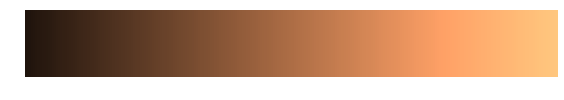

In [5]:
import matplotlib.colors as colors

first = int((128*2)-np.round(255*(1.-0.4)))
second = (256-first)

colors1 = plt.cm.copper(np.linspace(0.1, 1.0, first))
#colors2 = plt.cm.Wistia_r(np.linspace(0.2, 1, second))

cols = np.vstack((colors1))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', cols)

num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=mymap, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()

In [9]:
#fig.savefig('/data/pt_mar006/figures/cbar_dist.png',
#            format='png', dpi=300)

# # 1st distance map along the first gradient

In [6]:
vol_filename = '/data/pt_mar006/subjects_group/similarity_sd33_grad01.nii.gz'

surfLH_fileout = '/data/pt_mar006/components/sd33_dist_comp1_lh.mgz' 
surfRH_fileout = '/data/pt_mar006/components/sd33_dist_comp1_rh.mgz'

#dist_comp1_lh = map_to_surf(vol_filename, 'lh', surfLH_fileout)
#dist_comp1_rh = map_to_surf(vol_filename, 'rh', surfRH_fileout)

dist_comp1_lh = nb.load(surfLH_fileout).get_data().reshape(10242,)
dist_comp1_rh = nb.load(surfRH_fileout).get_data().reshape(10242,)

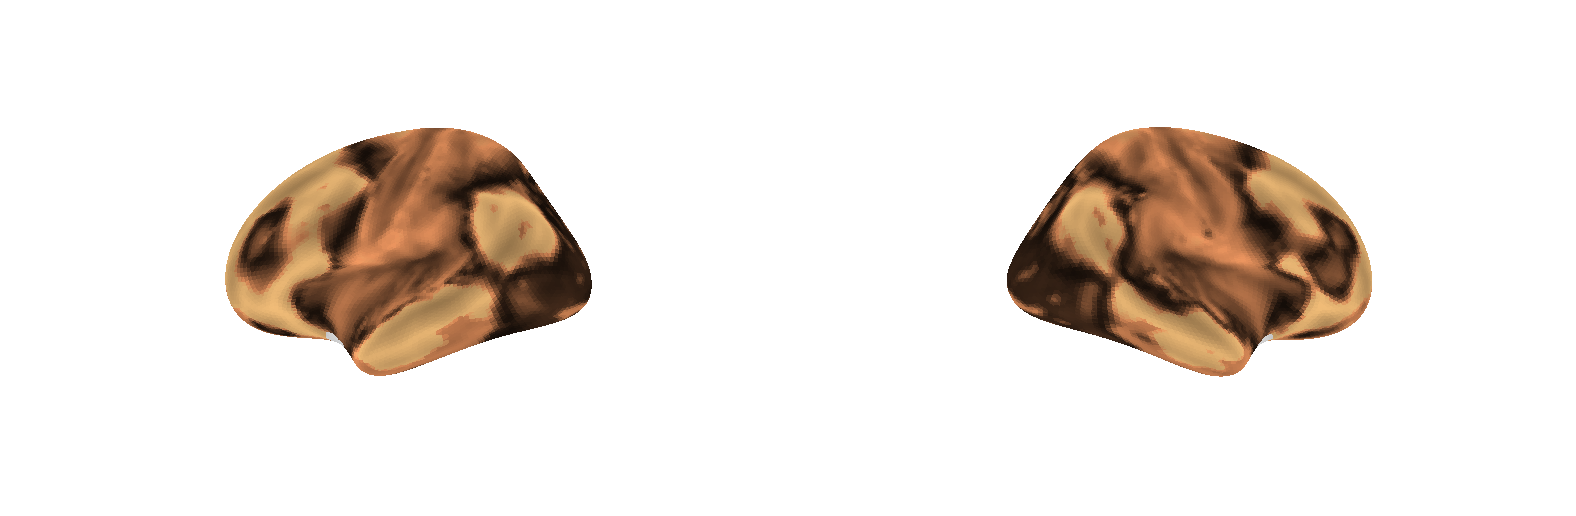

In [23]:
my_min = 0
my_max = 2

figure = plot_surf_infl(fs5, 
                        fsize=(28,9),
                        surf_map_l = dist_comp1_lh, 
                        surf_map_r = dist_comp1_rh,
                        vmin = my_min,
                        vmax = my_max,
                        threshold = None,
                        alpha = 1.,
                        cmap = mymap,
                        mask_lh = cort_lh,
                        mask_rh = cort_rh)

# #concordance map

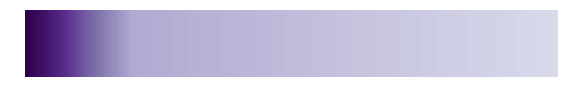

In [19]:
import matplotlib.colors as colors

first = int((128*2)-np.round(255*(1.-0.2)))
second = (256-first)

#plot
colors1 = plt.cm.PuOr_r(np.linspace(0.0, 0.3, first))
colors2 = plt.cm.PuOr_r(np.linspace(0.3, 0.4, second))

##CBARplot
#colors1 = plt.cm.PuOr_r(np.linspace(0., 0.3, first))
#colors2 = plt.cm.PuOr_r(np.linspace(0.3, 0.5, second))

cols = np.vstack((colors1, colors2))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', cols)

num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=mymap, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()

# # smooth concordance

In [28]:
from nipype.interfaces.fsl import maths

data_dir   = '/data/pt_mar006/stroke_intrasubject/'
subject_id = 'sd33'
conc_name  = 'conc_ccc.nii.gz'

vol_filename = os.path.join(data_dir, subject_id, conc_name)
vol_fileSmoo = os.path.join(data_dir, subject_id, 'conc_ccc_smoo.nii.gz')


smooth = maths.IsotropicSmooth()
smooth.inputs.in_file  = vol_filename
smooth.inputs.fwhm     = 6
smooth.inputs.out_file = vol_fileSmoo
print smooth.cmdline
#smooth.run()



fslmaths /data/pt_mar006/stroke_intrasubject/sd33/conc_ccc.nii.gz -s 2.54797 /data/pt_mar006/stroke_intrasubject/sd33/conc_ccc_smoo.nii.gz


In [59]:
surfLH_fileout = os.path.join(data_dir, subject_id, 'conc_ccc_lh_Smoo.mgz') 
surfRH_fileout = os.path.join(data_dir, subject_id, 'conc_ccc_rh_Smoo.mgz')

#H_lh = map_to_surf(vol_fileSmoo, 'lh', surfLH_fileout)
#H_rh = map_to_surf(vol_fileSmoo, 'rh', surfRH_fileout)

H_lh = nb.load(surfLH_fileout).get_data().reshape(10242,)
H_rh = nb.load(surfRH_fileout).get_data().reshape(10242,)


In [60]:
H_lh.min(), H_lh.max()

(-0.00076017145, 0.44951233)

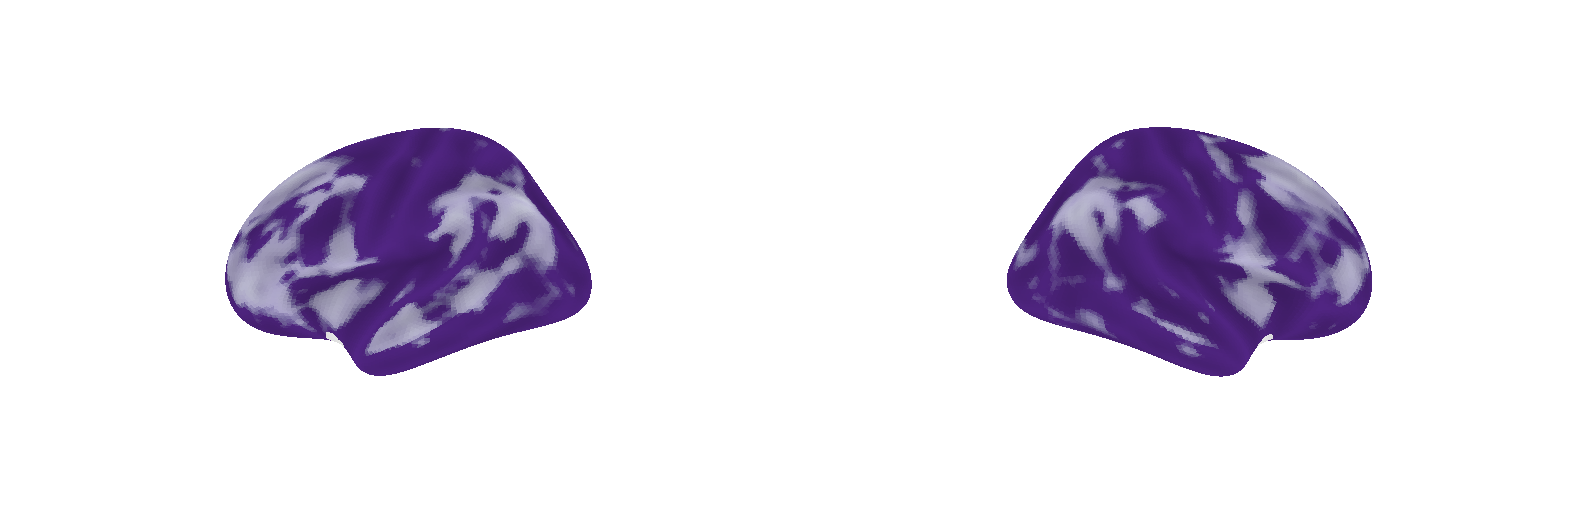

In [61]:
my_min = 0.14
my_max = 0.45

figure = plot_surf_infl(fs5, 
                        fsize=(28,9),
                        surf_map_l = H_lh, 
                        surf_map_r = H_rh,
                        vmin = my_min,
                        vmax = my_max,
                        threshold = None,
                        alpha = 1.,
                        cmap = mymap,
                        mask_lh = cort_lh,
                        mask_rh = cort_rh)
